In [20]:
%matplotlib inline
from pyspark.context import SparkContext
import datetime
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

In [2]:
sc = SparkContext.getOrCreate()
truePositivesPath = "../truePositives/*.csv"
trueNegativesPath = "../trueNegatives/*.csv"

In [3]:
def isTimeStamp(date_text):
    if date_text is None: 
        return False
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        return True
    except ValueError, TypeError:
        return False

In [18]:
def make_word_cloud(mask_file_path, text, title):
    """This method creates a word cloud based on the word count from the given text."""
    d = path.dirname(".")
    mask_image = np.array(Image.open(path.join(d, mask_file_path)))
    stopwords = set(STOPWORDS)
    stopwords.add("said")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("amp")
    stopwords.add("RT")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask_image, stopwords=stopwords)
    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, title+".png"))
    
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.figure()
    plt.show() 

In [5]:
tp_dataframe = spark.read.options(header="true", parserLib="univocity").csv(truePositivesPath)

tn_dataframe = spark.read.options(header="true", parserLib="univocity").csv(trueNegativesPath)

In [7]:
tp_rdd = tp_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))
                     
tn_rdd = tn_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))
                     
            
print tp_rdd.count()
print tn_rdd.count()

85281
793


In [10]:
tp_text_rdd = tp_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))])
tn_text_rdd = tn_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))])

tp_text_rdd.take(5)
tn_text_rdd.take(5)


[['@P727 @elonmusk However   Lets wait for one right now... May be iphone8 can be an innovation..! (2/2)'],
 ['@P727 @elonmusk Yeah! all knows @elonmusk as father of innovation of present decade same as Steve Jobs. Sure,  https://t.co/S11V8gAGhM'],
 ["@P727 They should buy @elonmusk 's brain and actions. Money don't make people innovative. Sim. Innovation alone not  https://t.co/XRFnikz9mb"],
 ['Tesla needs cash (which Apple has). Apple needs innovation (which Tesla has). Should Apple buy Tesla?#acquisition #rumors #Netflix #Disney'],
 ["Four of the wildest ideas from Amazon's Jeff Bezos https://t.co/9ioANNpbUw via @usatoday"]]

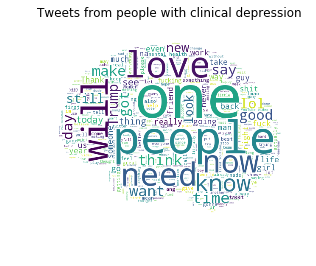

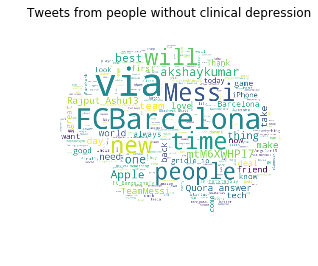

In [21]:
tp_collect = tp_text_rdd.collect()
tn_collect = tn_text_rdd.collect()

tp_text = ''.join(str(r) for v in tp_collect for r in v)
tn_text = ''.join(str(r) for v in tn_collect for r in v)

tp_title = "Tweets from people with clinical depression"
tn_title = "Tweets from people without clinical depression"
make_word_cloud("brain1.jpg", tp_text, tp_title)
make_word_cloud("brain1.jpg", tn_text, tn_title)